In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

<b style="color:black;">GETTING DATA</b>


In [33]:
start = '2012-01-01'
end = '2022-12-21'
stock = 'GOOG'

data = yf.download(stock, start, end)

[*********************100%%**********************]  1 of 1 completed


In [34]:
data.reset_index(inplace=True)

In [35]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,16.262545,16.641375,16.248346,16.573130,16.573130,147611217
1,2012-01-04,16.563665,16.693678,16.453827,16.644611,16.644611,114989399
2,2012-01-05,16.491436,16.537264,16.344486,16.413727,16.413727,131808205
3,2012-01-06,16.417213,16.438385,16.184088,16.189817,16.189817,108119746
4,2012-01-09,16.102144,16.114599,15.472754,15.503389,15.503389,233776981
...,...,...,...,...,...,...,...
2756,2022-12-14,95.540001,97.220001,93.940002,95.309998,95.309998,26452900
2757,2022-12-15,93.540001,94.029999,90.430000,91.199997,91.199997,28298800
2758,2022-12-16,91.199997,91.750000,90.010002,90.860001,90.860001,48485500
2759,2022-12-19,90.879997,91.199997,88.925003,89.150002,89.150002,23020500


In [36]:
#moving average
ma_100_days = data.Close.rolling(100).mean()

<b style="color:black;">EDA</b>

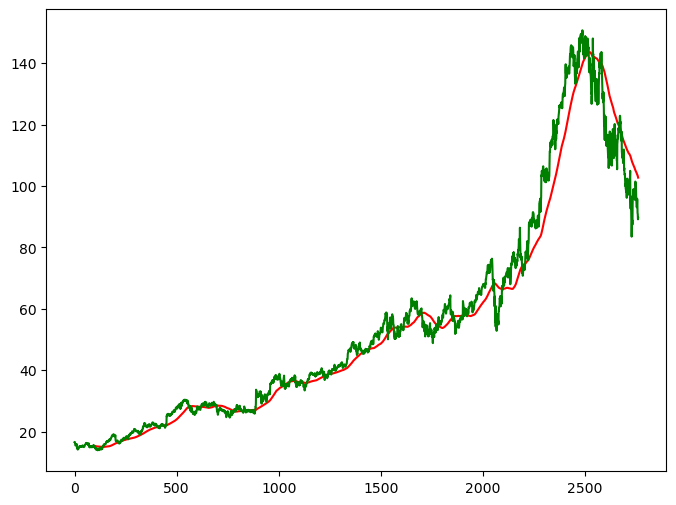

In [37]:
plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r')
plt.plot(data.Close, 'g')
plt.show()

In [38]:
ma_200_days = data.Close.rolling(200).mean()

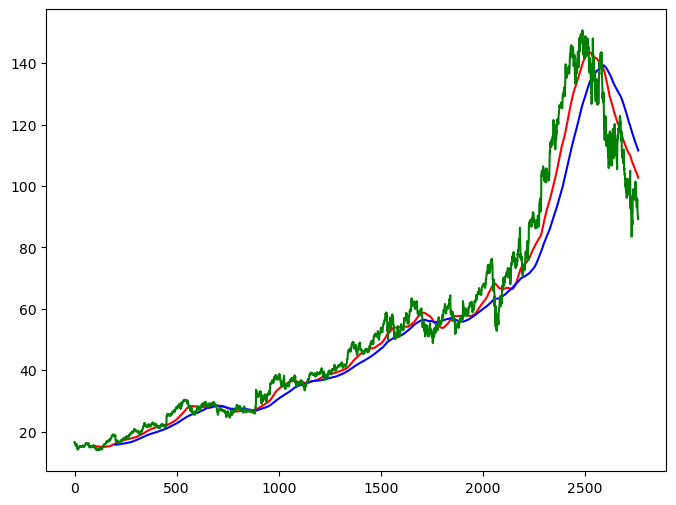

In [39]:
plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r')
plt.plot(ma_200_days,'b')
plt.plot(data.Close,'g')
plt.show()

In [9]:
data.dropna(inplace=True)

<b style="color:black;">Splitting into training and testing data</b>


In [10]:
data_train = pd.DataFrame(data.Close[0: int(len(data)*0.80)])
data_test = pd.DataFrame(data.Close[int(len(data)*0.80): len(data)])

In [11]:
data_train.shape[0]

2208

In [12]:
data_test.shape[0]

553

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [14]:
data_train_scale = scaler.fit_transform(data_train)

In [15]:
x = []
y = []

for i in range(100, data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i])
    y.append(data_train_scale[i,0])
    

In [16]:
x, y = np.array(x), np.array(y)

In [18]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

<b style="color:black;">Model deployment</b>


In [19]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True,
               input_shape = ((x.shape[1],1))))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation='relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units =1))

In [20]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [21]:
model.fit(x,y, epochs = 50, batch_size =32, verbose =1)

Epoch 1/50
66/66 [==============================] - 48s 560ms/step - loss: 0.0332
Epoch 2/50
66/66 [==============================] - 37s 568ms/step - loss: 0.0078
Epoch 3/50
66/66 [==============================] - 38s 576ms/step - loss: 0.0059
Epoch 4/50
66/66 [==============================] - 37s 559ms/step - loss: 0.0053
Epoch 5/50
66/66 [==============================] - 43s 647ms/step - loss: 0.0058
Epoch 6/50
66/66 [==============================] - 41s 615ms/step - loss: 0.0047
Epoch 7/50
66/66 [==============================] - 40s 610ms/step - loss: 0.0045
Epoch 8/50
66/66 [==============================] - 42s 638ms/step - loss: 0.0047
Epoch 9/50
66/66 [==============================] - 39s 590ms/step - loss: 0.0046
Epoch 10/50
66/66 [==============================] - 41s 626ms/step - loss: 0.0041
Epoch 11/50
66/66 [==============================] - 41s 616ms/step - loss: 0.0038
Epoch 12/50
66/66 [==============================] - 39s 591ms/step - loss: 0.0044
Epoch 13/50
6

In [23]:
pas_100_days = data_train.tail(100)

In [24]:
data_test = pd.concat([pas_100_days, data_test], ignore_index=True)

In [25]:
data_test_scale  =  scaler.fit_transform(data_test)

In [26]:
x = []
y = []

for i in range(100, data_test_scale.shape[0]):
    x.append(data_test_scale[i-100:i])
    y.append(data_test_scale[i,0])
x, y = np.array(x), np.array(y)

In [27]:
y_predict = model.predict(x)

18/18 [==============================] - 5s 157ms/step


In [28]:
scale =1/scaler.scale_

In [29]:
y_predict = y_predict*scale

In [30]:
y = y*scale

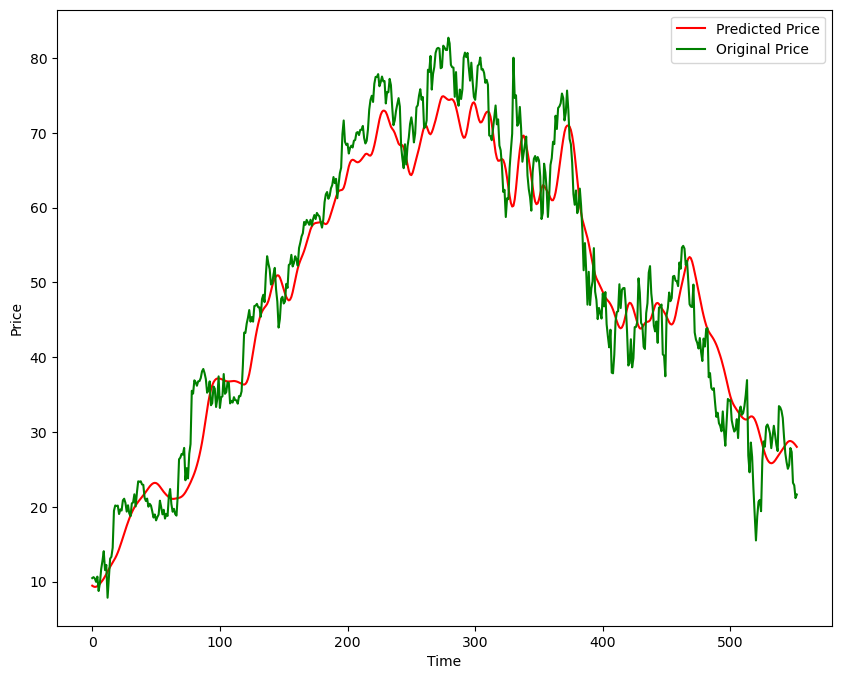

In [31]:
plt.figure(figsize=(10,8))
plt.plot(y_predict, 'r', label = 'Predicted Price')
plt.plot(y, 'g', label = 'Original Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
model.save('Stock Predictions Model.keras')